# Information criterion measurements:

Peform imports and initial setup:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge, ARDRegression
import spiral_model_comparison as smc
from gzbuilderspirals import fitting
from gzbuilderspirals import rThetaFromXY, xyFromRTheta

Loading NSA catalog
Loading Zooniverse classification dump
Obtaining available frame montages


Load the list of subject IDs

In [3]:
with open('subject-id-list.csv', 'r') as f:
        subjectIds = np.array([int(n) for n in f.read().split('\n')])

Perform initial setup for the test galaxy

In [4]:
chosenId = subjectIds[0]
gal, angle = smc.get_galaxy_and_angle(chosenId)
classifications, picArray, deprojectedImage = smc.get_image(
    gal, chosenId, angle
)
galaxy_object = smc.get_galaxy_spirals(
    gal, angle, chosenId, classifications
)

deprojectedArm = galaxy_object.deprojectArms()[1]

getInfo = lambda f: (
    f['clf']['spline'].scores_[-1],
    f['clf']['spline_degree'] + 2,
    f['params']['r_ordered'].shape[0]
)

Working on galaxy 21096909
	- USING MONTAGED IMAGE
	- Getting galaxy rotation
	- Clustering arms
	- Using saved distances
	- Fitting arms and errors


/Users/tlingard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


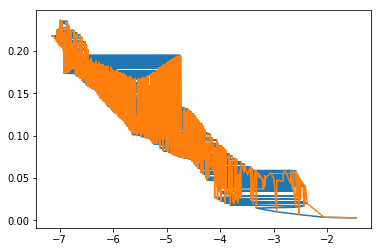

In [5]:
r, theta = rThetaFromXY(*deprojectedArm.normalise(deprojectedArm.cleanedCloud).T)
a = np.argsort(r)
plt.plot(np.unwrap(theta[a]), r[a])
b = np.argsort(np.unwrap(theta[a]))
plt.plot(np.unwrap(theta[a])[b], r[a][b])

T = np.unwrap(theta[a])[b]
R = r[a][b]

In [62]:
br_clf_poly = BayesianRidge(
    normalize=True,
    compute_score=True,
    fit_intercept=True
)
# T += 2*np.pi
T_predict = np.linspace(min(T), max(T), 1000)

degree = 5
X = np.vander(T, degree+1)
X_predict = np.vander(T_predict, degree + 1)
br_clf_poly.fit(X, R)
r_br, r_br_std = br_clf_poly.predict(
    X_predict,
    return_std=True
)

In [63]:
br_clf_logsp = ARDRegression(
    normalize=False,
    compute_score=True,
    fit_intercept=True
)
X_Theta = np.vander(T, 2)
br_clf_logsp.fit(X_Theta, np.log(R))
r_br_log_spiral_logged, r_br_log_spiral_std = br_clf_logsp.predict(
    X_Theta,
    return_std=True
)

In [64]:
br_clf_poly.coef_

array([-1.55127748e-04, -1.94152610e-03, -1.97122101e-03,  6.35563834e-02,
        2.61602877e-01,  0.00000000e+00])

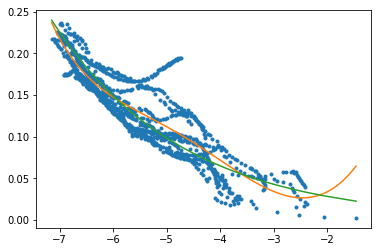

In [65]:
plt.plot(T, R, '.')
plt.plot(T_predict, r_br)
plt.plot(T, np.exp(r_br_log_spiral_logged))
k = sum(br_clf_poly.coef_ != 0)

In [57]:
print('Polynomial:\n\tAIC:', smc.AIC(br_clf_poly.scores_[-1], k + 1, T.shape[0]),
    '\n\tBIC:', smc.BIC(br_clf_poly.scores_[-1], k + 1, T.shape[0]))
print('Log spiral:\n\tAIC:', smc.AIC(br_clf_logsp.scores_[-1], k + 1, T.shape[0], log_transform=True, y=R),
    '\n\tBIC:', smc.BIC(br_clf_logsp.scores_[-1], k + 1, T.shape[0], log_transform=True, y=R)
)

Polynomial:
	AIC: -5258.199339648277 
	BIC: -5228.126646897963
Log spiral:
	AIC: -6621.785293461067 
	BIC: -6591.712600710754


In [ ]:
def polyFit(T, r):
    """Given the (unwrapped and ordered) theta and r values of
    cleaned points in a spiral, fit a low-order polynomial using
    ARDRegression
    """
    T_center = T - np.average(T, axis=0)
    r_center = r - np.average(r, axis=0)
    
    clf = ARDRegression(
        compute_score=True,
        fit_intercept=False,
        copy_X=True
    )

    T_predict = np.linspace(min(T), max(T), 1000)

    X = np.vander(T_center, N=50)
    X_predict = np.vander(T_predict, N=50)

    clf.fit(X, r_center)
    r_br, r_br_std = clf.predict(
        X_predict,
        return_std=True
    )
    return {
        'AIC': smc.AIC(clf.scores_[-1], sum(clf.coef_ != 0), T.shape[0]),
        'BIC': smc.BIC(clf.scores_[-1], sum(clf.coef_ != 0), T.shape[0]),
        'clf': clf,
        't': T_predict + T_center,
        'r': r_br + r_center,
        'r_std': r_br_std,
    }